In [2]:
from pygrounds.utils import S3Utils, DSWarehouse
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate

In [3]:
query = \
"""
  SELECT
DISTINCT merged_eligibility.gr_lookup_id AS pid,
         2020 - year_of_birth AS age
    FROM `grnds-frankie.covid_guidance_engine.amazon__worksite_eligiblity` AS worksite_eligibility
    JOIN `national-claims-warehouse.bronze.merged_eligibility` AS merged_eligibility
      ON worksite_eligibility.gr_lookup_id = merged_eligibility.gr_lookup_id
   WHERE merged_eligibility.gr_lookup_id_type = 'pid'
"""

In [4]:
dsw = DSWarehouse()
age_distribution = dsw.query_to_df(query)

In [5]:
age_distribution.to_csv('amazon_age_distribution.csv')

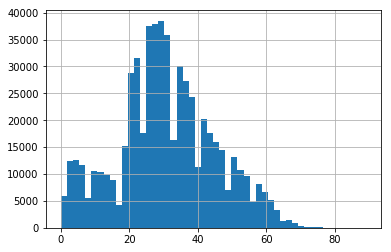

In [9]:
age_distribution.age.hist(bins=50)
plt.show()

In [54]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from pyseir.inference import model_fitter
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate
import json
import dill as pickle
from pyseir import load_data
from pyseir.inference.whitelist_generator import WhitelistGenerator
from pyseir.utils import get_run_artifact_path, RunArtifact
from pyseir.deployment.demographic_mapper import DemographicMapper, CovidMeasure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
metadata = load_data.load_county_metadata()

In [8]:
metadata

,fips,state,county,total_population,population_density,housing_density,age_distribution,age_bin_edges
0,01001,Alabama,Autauga County,55601,91.8,37.2,"[3364, 3423, 3882, 3755, 3173, 3705, 3461, 362...","[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,..."
1,01003,Alabama,Baldwin County,218022,114.6,65.5,"[11955, 12802, 13981, 12932, 11108, 12471, 120...","[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,..."
2,01005,Alabama,Barbour County,24881,31.0,13.4,"[1284, 1448, 1509, 1451, 1472, 1796, 1670, 153...","[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,..."
3,01007,Alabama,Bibb County,22400,36.8,14.4,"[1285, 1171, 1326, 1270, 1303, 1726, 1601, 151...","[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,..."
4,01009,Alabama,Blount County,57840,88.9,37.0,"[3460, 3635, 3902, 3668, 3178, 3564, 3370, 351...","[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,..."
...,...,...,...,...,...,...,...,...
3137,56037,Wyoming,Sweetwater County,43051,4.2,1.8,"[2949, 3155, 3311, 3015, 2527, 2832, 3191, 338...","[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,..."
3138,56039,Wyoming,Teton County,23081,5.3,3.2,"[1132, 1252, 1202, 983, 1078, 1889, 2028, 2065...","[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,..."
3139,56041,Wyoming,Uinta County,20299,10.1,4.2,"[1486, 1635, 1747, 1458, 999, 1154, 1242, 1460...","[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,..."
3140,56043,Wyoming,Washakie County,7885,3.8,1.7,"[406, 452, 560, 553, 352, 363, 416, 487, 440, ...","[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,..."


array(['District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [13]:
for state in metadata.state.unique()[9:]:
    if state != 'California':
        try:
            model_fitter.run_state(state=state, 
                           states_only=False, 
                           with_age_structure=True)
        except:
            next

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 99.69                   |     Ncalls=500 (500 total)     |
| EDM = 0.0275 (Goal: 5E-06)    |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 68.71                   |     Ncalls=181 (181 total)     |
| EDM = 0.152 (Goal: 5E-06)     |            up = 0.5         

------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 40.33                   |     Ncalls=505 (509 total)     |
| EDM = 34.1 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 54.63                   |     Ncalls=418 (418 total)  

/anaconda3/envs/pyseir/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/anaconda3/envs/pyseir/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


------------------------------------------------------------------
| FCN = 53.13                   |     Ncalls=463 (464 total)     |
| EDM = 0.152 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 55.35                   |     Ncalls=319 (319 total)     |
| EDM = 0.342 (Goal: 5E-06)     |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 125.3                   |     Ncalls=239 (239 total)     |
| EDM = 0.161 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 95.72                   |     Ncalls=272 (277 total)     |
| EDM = 95 (Goal: 5E-06)        |            up = 0.5         

------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 113.1                   |     Ncalls=134 (145 total)     |
| EDM = 4.62E+13 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 50.05                   |     Ncalls=344 (350 total)  

------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 54.7                    |     Ncalls=411 (411 total)     |
| EDM = 0.241 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 31.79                   |     Ncalls=347 (350 total)  

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 82.84                   |     Ncalls=384 (389 total)     |
| EDM = 3.27 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 54.77                   |     Ncalls=332 (336 total)     |
| EDM = 4.78 (Goal: 5E-06)      |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 103.5                   |     Ncalls=565 (565 total)     |
| EDM = 0.376 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 56.81                   |     Ncalls=311 (316 total)     |
| EDM = 0.0913 (Goal: 5E-06)    |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 64.28                   |     Ncalls=466 (471 total)     |
| EDM = 414 (Goal: 5E-06)       |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 63.33                   |     Ncalls=244 (246 total)     |
| EDM = 34.8 (Goal: 5E-06)      |            up = 0.5         

------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 41.72                   |     Ncalls=701 (707 total)     |
| EDM = 0.403 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------


/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 30.58                   |     Ncalls=313 (317 total)     |
| EDM = 35.6 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 44.45                   |     Ncalls=257 (260 total)     |
| EDM = 3.53 (Goal: 5E-06)      |            up = 0.5         

------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 67.26                   |     Ncalls=514 (518 total)     |
| EDM = 58.4 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 76.35                   |     Ncalls=485 (489 total)  

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 39.79                   |     Ncalls=492 (492 total)     |
| EDM = 0.074 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 55.49                   |     Ncalls=322 (326 total)     |
| EDM = 1.63 (Goal: 5E-06)      |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 108.9                   |     Ncalls=428 (428 total)     |
| EDM = 0.0202 (Goal: 5E-06)    |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 61.47                   |     Ncalls=271 (275 total)     |
| EDM = 0.835 (Goal: 5E-06)     |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 91.87                   |     Ncalls=461 (465 total)     |
| EDM = 0.246 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 73.08                   |     Ncalls=222 (225 total)     |
| EDM = 3.05 (Goal: 5E-06)      |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 74.85                   |     Ncalls=357 (358 total)     |
| EDM = 1.86 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 96.6                    |     Ncalls=320 (328 total)     |
| EDM = 515 (Goal: 5E-06)       |            up = 0.5         

------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 49.87                   |     Ncalls=491 (495 total)     |
| EDM = 32.5 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 36.03                   |     Ncalls=500 (503 total)  

------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 42.47                   |     Ncalls=414 (418 total)     |
| EDM = 0.156 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 51.53                   |     Ncalls=479 (483 total)  

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 54.98                   |     Ncalls=316 (319 total)     |
| EDM = 0.32 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 94.02                   |     Ncalls=213 (217 total)     |
| EDM = 366 (Goal: 5E-06)       |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 31.71                   |     Ncalls=284 (284 total)     |
| EDM = 0.19 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 39.08                   |     Ncalls=228 (234 total)     |
| EDM = 2.79 (Goal: 5E-06)      |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 37.9                    |     Ncalls=300 (304 total)     |
| EDM = 6.72 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 23.54                   |     Ncalls=146 (148 total)     |
| EDM = 0.0274 (Goal: 5E-06)    |            up = 0.5         

------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 39.22                   |     Ncalls=392 (397 total)     |
| EDM = 0.244 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 39.11                   |     Ncalls=523 (528 total)  

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 68.72                   |     Ncalls=549 (552 total)     |
| EDM = 0.465 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 84.86                   |     Ncalls=192 (196 total)     |
| EDM = 4.96 (Goal: 5E-06)      |            up = 0.5         

------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 59.65                   |     Ncalls=306 (312 total)     |
| EDM = 2.62E+03 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 85.97                   |     Ncalls=592 (592 total)  

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 24.57                   |     Ncalls=666 (671 total)     |
| EDM = 5.56 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 114.8                   |     Ncalls=476 (476 total)     |
| EDM = 0.599 (Goal: 5E-06)     |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
User function arguments:
                 R0 = +3.400000
                 t0 = +40.000038
                eps = +0.400000
            t_break = +10.000000
      test_fraction = +0.100000
      hosp_fraction = +0.999999
    log10_I_initial = +2.000000
Original python exception in user function:
LinAlgError: Array must not contain infs or NaNs
  File "/Users/xzhang/Documents/covid/covid-data-model/pyseir/inference/model_fitter.py", line 368, in _fit_seir
    model = self.run_model(**model_kwargs)
  File "/Users/xzhang/Documents/covid/covid-data-model/pyseir/inference/model_fitter.py", line 333, in run_mode

------------------------------------------------------------------
| FCN = 94.56                   |     Ncalls=332 (332 total)     |
| EDM = 0.543 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 41.77                   |     Ncalls=238 (241 total)     |
| EDM = 54.6 (Goal: 5E-06)      |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 92.07                   |     Ncalls=320 (326 total)     |
| EDM = 1.56E+03 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------


/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 27.45                   |     Ncalls=434 (436 total)     |
| EDM = 0.145 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 161.8                   |     Ncalls=129 (129 total)     |
| EDM = 0.742 (Goal: 5E-06)     |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 55.61                   |     Ncalls=533 (537 total)     |
| EDM = 14.9 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 36.31                   |     Ncalls=477 (477 total)     |
| EDM = 0.0515 (Goal: 5E-06)    |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 33.93                   |     Ncalls=888 (892 total)     |
| EDM = 1.29 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 54.28                   |     Ncalls=175 (179 total)     |
| EDM = 1.71E+03 (Goal: 5E-06)  |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 110                     |     Ncalls=384 (389 total)     |
| EDM = 13.1 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 57.81                   |     Ncalls=177 (181 total)     |
| EDM = 15.6 (Goal: 5E-06)      |            up = 0.5         

------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 26.7                    |     Ncalls=465 (469 total)     |
| EDM = 0.272 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 38.15                   |     Ncalls=211 (215 total)  

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 29.08                   |     Ncalls=486 (486 total)     |
| EDM = 0.0705 (Goal: 5E-06)    |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 91.72                   |     Ncalls=254 (256 total)     |
| EDM = 0.369 (Goal: 5E-06)     |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 111.8                   |     Ncalls=346 (347 total)     |
| EDM = 0.0659 (Goal: 5E-06)    |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 78.93                   |     Ncalls=145 (149 total)     |
| EDM = 315 (Goal: 5E-06)       |            up = 0.5         

------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 62.96                   |     Ncalls=317 (322 total)     |
| EDM = 0.124 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 36.58                   |     Ncalls=311 (314 total)  

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 53.2                    |     Ncalls=205 (207 total)     |
| EDM = 0.108 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 51.04                   |     Ncalls=135 (135 total)     |
| EDM = 0.246 (Goal: 5E-06)     |            up = 0.5         

------------------------------------------------------------------


/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 64.01                   |     Ncalls=469 (472 total)     |
| EDM = 8.59 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 28.45                   |     Ncalls=261 (267 total)     |
| EDM = 2.71 (Goal: 5E-06)      |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 102.9                   |     Ncalls=402 (412 total)     |
| EDM = 1.8 (Goal: 5E-06)       |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 63.11                   |     Ncalls=267 (274 total)     |
| EDM = 168 (Goal: 5E-06)       |            up = 0.5         

------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 53.31                   |     Ncalls=152 (155 total)     |
| EDM = 32.9 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 97.1                    |     Ncalls=246 (248 total)  

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 67.33                   |     Ncalls=524 (524 total)     |
| EDM = 0.388 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 89.34                   |     Ncalls=185 (189 total)     |
| EDM = 223 (Goal: 5E-06)       |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 67.36                   |     Ncalls=406 (408 total)     |
| EDM = 0.583 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 52.9                    |     Ncalls=189 (194 total)     |
| EDM = 0.399 (Goal: 5E-06)     |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 29.68                   |     Ncalls=466 (468 total)     |
| EDM = 0.102 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 51.5                    |     Ncalls=180 (183 total)     |
| EDM = 0.195 (Goal: 5E-06)     |            up = 0.5         

------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 57.07                   |     Ncalls=431 (438 total)     |
| EDM = 3.77 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 37.77                   |     Ncalls=245 (252 total)  

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 44.74                   |     Ncalls=530 (530 total)     |
| EDM = 0.193 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 24.54                   |     Ncalls=347 (351 total)     |
| EDM = 0.0964 (Goal: 5E-06)    |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 61.12                   |     Ncalls=270 (273 total)     |
| EDM = 0.191 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 59.11                   |     Ncalls=172 (174 total)     |
| EDM = 0.267 (Goal: 5E-06)     |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 33.01                   |     Ncalls=450 (454 total)     |
| EDM = 0.64 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------


/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 138.8                   |     Ncalls=344 (349 total)     |
| EDM = 41.9 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 48.2                    |     Ncalls=215 (217 total)     |
| EDM = 0.976 (Goal: 5E-06)     |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 58.12                   |     Ncalls=275 (275 total)     |
| EDM = 0.214 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 58.83                   |     Ncalls=197 (200 total)     |
| EDM = 0.834 (Goal: 5E-06)     |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/anaconda3/envs/pyseir/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


------------------------------------------------------------------
| FCN = 42.31                   |     Ncalls=277 (284 total)     |
| EDM = 2.72 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 30.83                   |     Ncalls=235 (239 total)     |
| EDM = 0.629 (Goal: 5E-06)     |            up = 0.5         

------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 157.7                   |     Ncalls=349 (353 total)     |
| EDM = 3.18 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------


/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 79.76                   |     Ncalls=402 (408 total)     |
| EDM = 27.3 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 44.11                   |     Ncalls=203 (209 total)     |
| EDM = 0.235 (Goal: 5E-06)     |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 80                      |     Ncalls=532 (535 total)     |
| EDM = 0.353 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 102                     |     Ncalls=231 (231 total)     |
| EDM = 0.421 (Goal: 5E-06)     |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 60.46                   |     Ncalls=416 (416 total)     |
| EDM = 0.172 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 57.89                   |     Ncalls=139 (141 total)     |
| EDM = 257 (Goal: 5E-06)       |            up = 0.5         

------------------------------------------------------------------


/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 122.8                   |     Ncalls=659 (663 total)     |
| EDM = 0.466 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 116.4                   |      Ncalls=94 (94 total)      |
| EDM = 0.637 (Goal: 5E-06)     |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 59.39                   |     Ncalls=627 (631 total)     |
| EDM = 0.219 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 63.29                   |     Ncalls=117 (117 total)     |
| EDM = 0.0207 (Goal: 5E-06)    |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 41.57                   |     Ncalls=413 (416 total)     |
| EDM = 1.37 (Goal: 5E-06)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 72.11                   |     Ncalls=221 (228 total)     |
| EDM = 478 (Goal: 5E-06)       |            up = 0.5         

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 49.67                   |     Ncalls=619 (619 total)     |
| EDM = 0.0249 (Goal: 5E-06)    |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------


In [3]:
age_distribution = pd.read_csv('amazon_age_distribution.csv')
age_counts = age_distribution.age.value_counts().sort_index() \
                    .rename('count') \
                    .reset_index().rename(columns={'index': 'age'})
age_counts['pmf'] = age_counts['count'] / age_counts['count'].sum()
age_counts['age']
age_distribution = scipy.interpolate.interp1d(np.append(age_counts['age'], 120), 
                                              np.append(age_counts['pmf'], 0))

In [86]:
dm.IHR['HICU']['per_capita_day']

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [89]:
dm.IHR['HICU']['per_capita'].shape

(16, 366)

In [ ]:
dm._calculate_age_specific_IFR(measure_unit)

In [92]:
for fips in ['06']:
    model_path = get_run_artifact_path(fips, RunArtifact.MLE_FIT_MODEL)
    model = pickle.loads(open(model_path,'rb').read())

    fit_results_path = get_run_artifact_path(fips, RunArtifact.MLE_FIT_RESULT)
    with open(fit_results_path) as f:
        fit_results = json.load(f)
    fit_results = pd.DataFrame(fit_results).set_index('fips').loc[fips].to_dict()

    dm = DemographicMapper(fips=fips,
                      mle_model=model,
                      fit_results=fit_results,
                      measure_units=['per_capita', 'per_capita_day'],
                      measures=['IHR_icu',
                                 'IHR',
                                'IFR'],
                      target_age_distribution_pdf = age_distribution)
    results = dm.run()

/Users/xzhang/Documents/covid/covid-data-model/pyseir/deployment/demographic_mapper.py:239: RuntimeWarning: divide by zero encountered in true_divide
  mortality_rate_ICU[:, idx_inadequate_icu_bed] = \
/Users/xzhang/Documents/covid/covid-data-model/pyseir/deployment/demographic_mapper.py:248: RuntimeWarning: divide by zero encountered in true_divide
  mortality_rate_NonICU[:, idx_inadequate_hgen_bed] = \


In [44]:
(dm.predictions_by_age['I'].T)

array([[   7.17391071,    7.31379212,    7.4873759 , ...,    5.44545458,
           4.2089372 ,    4.1342419 ],
       [   9.12350269,    9.71024776,    9.9695284 , ...,    6.88922565,
           5.22426348,    5.06868316],
       [  11.08695135,   12.804966  ,   13.23841345, ...,    8.3517459 ,
           6.09130008,    5.7813982 ],
       ...,
       [2966.49112354, 1932.99201858, 1569.24423089, ...,  671.77411042,
         400.71176515,  347.4937488 ],
       [2940.79397939, 1913.8818822 , 1551.65097951, ...,  664.34492777,
         396.24970417,  343.72086603],
       [2913.02181369, 1893.52104801, 1533.06209886, ...,  656.44132122,
         391.50752161,  339.69346348]])

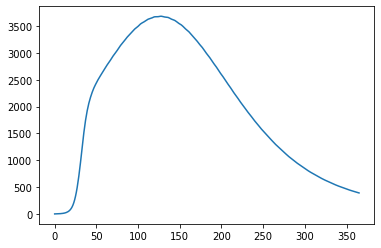

In [93]:
plt.plot(dm.parameters['t_list'],
         dm.predictions['HGen'])

Text(0, 0.5, 'I')

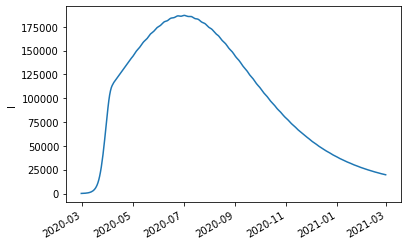

In [60]:
results['compartments']['I'].plot()
plt.ylabel('I')

In [22]:
from datetime import datetime
datetime.fromisoformat(dm.fit_results['t0_date'])

datetime.datetime(2020, 2, 29, 8, 15, 27, 13158)

In [105]:
def plot_mapper_results(results):
    for measure_unit in list(results.values())[0]:
        plt.figure()
        for measure_name in results:
            results[measure_name][measure_unit].plot(label=measure_name)
        plt.xlabel('dates')
        plt.ylabel(measure_unit)
        plt.legend()

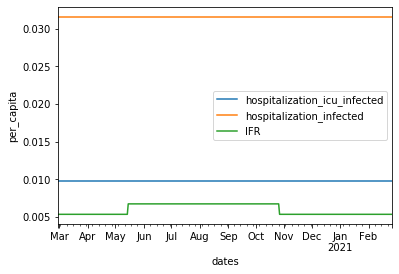

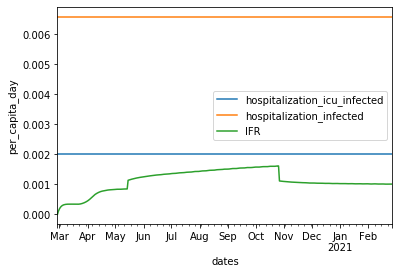

In [110]:
plot_mapper_results(results)

In [70]:
results['IFR']

{'per_capita': 2020-02-28    0.00059
 2020-02-29    0.00059
 2020-03-01    0.00059
 2020-03-02    0.00059
 2020-03-03    0.00059
                ...   
 2021-02-23    0.00059
 2021-02-24    0.00059
 2021-02-25    0.00059
 2021-02-26    0.00059
 2021-02-27    0.00059
 Length: 366, dtype: float64,
 'per_capita_day': 2020-02-28    0.000000
 2020-02-29    0.000102
 2020-03-01    0.000173
 2020-03-02    0.000224
 2020-03-03    0.000261
                 ...   
 2021-02-23    0.001011
 2021-02-24    0.001012
 2021-02-25    0.001011
 2021-02-26    0.001009
 2021-02-27    0.001008
 Length: 366, dtype: float64}

In [249]:
dm.hospitalization_probabilities

{'HGen': array([[0.00389814, 0.00389814, 0.00389814, ..., 0.00389814, 0.00389814,
         0.00389814],
        [0.00443674, 0.00443674, 0.00443674, ..., 0.00443674, 0.00443674,
         0.00443674],
        [0.01013107, 0.01013107, 0.01013107, ..., 0.01013107, 0.01013107,
         0.01013107],
        ...,
        [0.02689015, 0.02689015, 0.02689015, ..., 0.02689015, 0.02689015,
         0.02689015],
        [0.02432285, 0.02432285, 0.02432285, ..., 0.02432285, 0.02432285,
         0.02432285],
        [0.03963229, 0.03963229, 0.03963229, ..., 0.03963229, 0.03963229,
         0.03963229]]),
 'HICU': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.00106434, 0.00106434, 0.00106434, ..., 0.00106434, 0.00106434,
         0.00106434],
        ...,
        [0.01965725, 0.01965725, 0.01965725, ..., 0.01965725, 0.01965725,
         0.0196572

In [34]:
predictions = dm.generate_predictions()

CovidMeasure.MORTALITY_INFECTED


In [27]:
dm.parameters['mortality_rate_from_ICU']

array([0.38111157, 0.38050485, 0.3811634 , 0.38122723, 0.38193698,
       0.38176735, 0.38153483, 0.38406233, 0.38483591, 0.38586289,
       0.39139774, 0.39875619, 0.40476657, 0.41449098, 0.42190631,
       0.54383527])

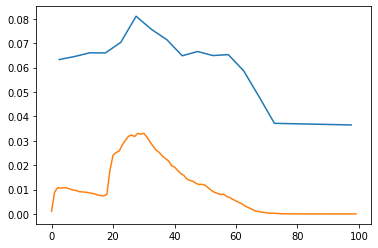

In [25]:
plt.plot([np.mean(tup) for tup in dm.parameters['age_groups']],
         dm.parameters['N'] / dm.parameters['N'].sum())
plt.plot(range(0, 100),
         age_distribution(range(0, 100)))

In [ ]:
plt.plot()

In [39]:
dm.generate_predictions()

CovidMeasure.MORTALITY_INFECTED


{'hospitalization_icu_infected':             0-5  5-10     10-15     15-20     20-25     25-30     30-35  \
 2020-02-28  0.0   0.0  0.001705  0.004498  0.006527  0.007826  0.009285   
 2020-02-29  0.0   0.0  0.001705  0.004498  0.006527  0.007826  0.009285   
 2020-03-01  0.0   0.0  0.001705  0.004498  0.006527  0.007826  0.009285   
 2020-03-02  0.0   0.0  0.001705  0.004498  0.006527  0.007826  0.009285   
 2020-03-03  0.0   0.0  0.001705  0.004498  0.006527  0.007826  0.009285   
 ...         ...   ...       ...       ...       ...       ...       ...   
 2021-02-23  0.0   0.0  0.001705  0.004498  0.006527  0.007826  0.009285   
 2021-02-24  0.0   0.0  0.001705  0.004498  0.006527  0.007826  0.009285   
 2021-02-25  0.0   0.0  0.001705  0.004498  0.006527  0.007826  0.009285   
 2021-02-26  0.0   0.0  0.001705  0.004498  0.006527  0.007826  0.009285   
 2021-02-27  0.0   0.0  0.001705  0.004498  0.006527  0.007826  0.009285   
 
                35-40     40-45     45-50     50-55   

In [41]:
results = dm.run()

CovidMeasure.MORTALITY_INFECTED


Text(0.5, 1.0, '06')

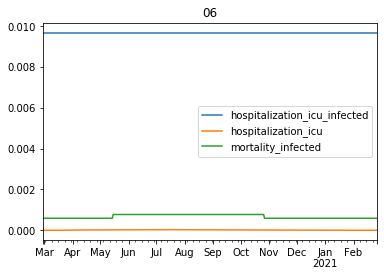

In [45]:
for k in results:
    results[k].plot(label=k)
plt.legend()
plt.title(fips)

In [42]:
for k in results:
    results[k].plot(lb)

{'hospitalization_icu_infected': 2020-02-28    0.009679
 2020-02-29    0.009679
 2020-03-01    0.009679
 2020-03-02    0.009679
 2020-03-03    0.009679
                 ...   
 2021-02-23    0.009679
 2021-02-24    0.009679
 2021-02-25    0.009679
 2021-02-26    0.009679
 2021-02-27    0.009679
 Length: 366, dtype: float64,
 'hospitalization_icu': 2020-02-28    1.608313e-08
 2020-02-29    2.066616e-08
 2020-03-01    2.575535e-08
 2020-03-02    3.174186e-08
 2020-03-03    3.905522e-08
                   ...     
 2021-02-23    2.564798e-06
 2021-02-24    2.529220e-06
 2021-02-25    2.497755e-06
 2021-02-26    2.468224e-06
 2021-02-27    2.437896e-06
 Length: 366, dtype: float64,
 'mortality_infected': 2020-02-28    0.00059
 2020-02-29    0.00059
 2020-03-01    0.00059
 2020-03-02    0.00059
 2020-03-03    0.00059
                ...   
 2021-02-23    0.00059
 2021-02-24    0.00059
 2021-02-25    0.00059
 2021-02-26    0.00059
 2021-02-27    0.00059
 Length: 366, dtype: float64}

In [ ]:
plt.plot(model.t_list, generate_predictions)

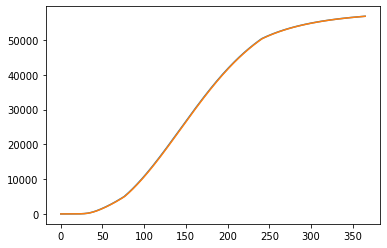

In [179]:
plt.plot(model.t_list, D.sum(axis=0))
plt.plot(model.t_list, dm.predictions['D'])

In [175]:
target_predictions['mortality_infected']

,0-5,5-10,10-15,15-20,20-25,25-30,30-35,35-40,40-45,45-50,50-55,55-60,60-65,65-70,70-75,75-120
2020-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-29,0.000003,0.000003,0.000012,0.000027,0.000040,0.000045,0.000051,0.000059,0.000066,0.000082,0.000082,0.000086,0.000105,0.000135,0.000148,0.000210
2020-03-01,0.000008,0.000008,0.000030,0.000066,0.000101,0.000113,0.000130,0.000151,0.000167,0.000208,0.000218,0.000229,0.000283,0.000356,0.000409,0.000591
2020-03-02,0.000014,0.000013,0.000049,0.000107,0.000170,0.000191,0.000222,0.000256,0.000282,0.000353,0.000381,0.000403,0.000499,0.000623,0.000738,0.001087
2020-03-03,0.000020,0.000018,0.000068,0.000148,0.000239,0.000270,0.000315,0.000364,0.000399,0.000502,0.000551,0.000584,0.000725,0.000901,0.001087,0.001629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-23,0.031529,0.058352,0.339010,0.562514,0.609828,0.633837,0.657121,0.696846,0.743391,0.795374,0.769290,0.777682,0.805073,0.844738,0.853279,0.868141
2021-02-24,0.031876,0.059026,0.342018,0.565879,0.613036,0.636934,0.660091,0.699598,0.745933,0.797578,0.771662,0.780008,0.807161,0.846475,0.854947,0.869641
2021-02-25,0.032224,0.059704,0.345025,0.569225,0.616221,0.640006,0.663036,0.702323,0.748449,0.799755,0.774007,0.782308,0.809224,0.848189,0.856593,0.871121
2021-02-26,0.032575,0.060387,0.348035,0.572552,0.619385,0.643056,0.665958,0.705024,0.750939,0.801907,0.776327,0.784583,0.811264,0.849882,0.858218,0.872582
